In [ ]:
def get_linfty(fun,a=0,b=1,nn=20):
    xx = linspace(a,b,2**n+1)
    return amax(absolute(fun(xx)))

def lagrangian_interpolation(x,q)
    n = q.shape
    Ln = zeros((n+1, len(x)))

    for i in xrange(n+1):
        Ln[i] = product([ (x-q[j])/(q[i]-q[j]) for j in xrange(n+1) if j != i], axis=0)

1.0
0.255355469387
0.180758289706
0.0267551952555
0.0188963408203
0.00169575481946
0.00120553875992
7.22534784003e-05
5.164948321e-05
2.21336984904e-06
1.58880542908e-06
5.11106992285e-08
3.68051016886e-08
9.2165391985e-10
6.65490273999e-10
1.34610239622e-11
1.0088055391e-11
1.31425426098e-12


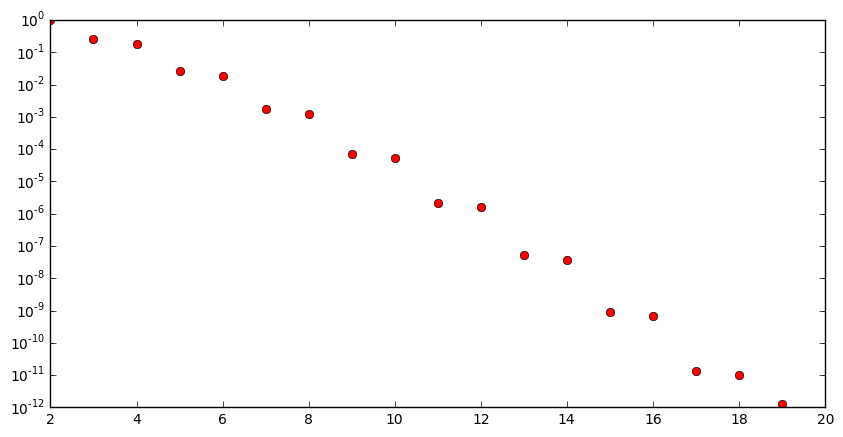

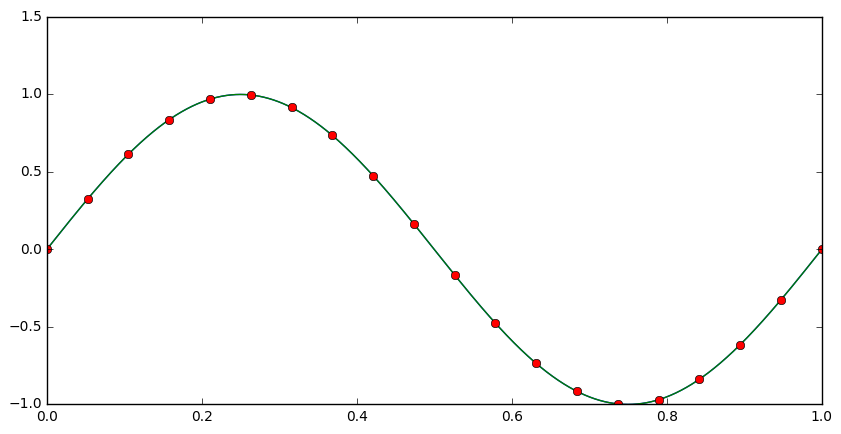

In [43]:
%matplotlib inline
from numpy import *
from pylab import *
#from sympy import *


ref = 2**20+1 # So that x_i+1 - x_i is exactly representable in base 2
x = linspace(0,1,ref)
figure(figsize=[10,5])



for n in xrange(2,20):
    # The interpolation points
    q = linspace(0,1,n+1)
    

    # The interpolation function
    f = lambda x: sin(2*pi*x)

    
    y = Ln.T.dot(f(q))
    
 

    #print abs(y-f(x))
    #print f(x)
    linfty=amax(absolute(y-f(x)))
   # t = symbols('t')
    #deri=diff(lambda x: sin(2*pi*x), 1.0,2)
    
    print linfty
    #figure(figsize=[10,5])
    _ = semilogy (n,linfty,'ro')
    

figure(figsize=[10,5])
_ = plot(x, f(x))
_ = plot(x, y)
_ = plot(q, f(q), 'ro')